## Investigating and Predicting the Effect of Variables on the Current Condition of Texas Bridges

This report aims to carry out an exploratory analysis of the 2019 Texas Bridge data, looking at selected continuous and categorical variables. The data will initially undergo several transformations to prepare for and facilitate the analysis process. Relationships between the investigated variables and the target variable will be looked at to draw preliminary conclusions of how they can predict bridge condition. Finally, a prediction model will be built based on these variables, to look at the relative influences of each on the target variable.

Specifically, we will be focussing on the effect of bridge: age (which will be derived from the 'Year' the bridge was built), the average daily traffic (number of vehicles; known as 'AverageDaily'), the percentage of traffic that is 'trucks' (known as 'Trucks_percent'), the dominant 'Material' the bridge is made from and the 'Design', on the current condition. The current condition score will be derived from the condition of the deck of the bridge ('Deck_rating'), condition of the superstructure ('Superstr_rating') and condition fo the substructure ('Substr_rating').

### Table of Contents

1. Section 1: Getting the Data Ready
      1. Excluding Rows with Missing Values and Older Bridges
      1. Grouping the Materials and Design
      1. Determining the Current Condition
      1. Finalising the Data for Analysis
      
2. Section 2: Exploring Relationships Between the Investigatory and Target Variables
      1. Correlation Matrix of the Continuous Variables
      1. Relationships Between the Categorical Variables
      1. Relationships Between the Categorical and Continuous Variables
      
3. Section 3: Creating the Prediction Model
      1. Preparing the Categorical Predictors
      1. Determining the Regression Coefficients
      2. Looking at How the Prediction Fits the Data 
      2. Conclusion


In [1]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Section 1: Getting the Data Ready

In this section we will prepare the data for analysis. As the dataset is extensive, and our predictions should reflect recent data, we will remove bridges that are older than a certain age. The number of categories within the material and design variables will be reduced, as some of these groups are considerably smaller and combining them would facilitate analysis. The target variable, current condition, will be dervied from the deck rating (Deck_rating), superstructure rating (Superstr_rating) and substructure rating (Substr_rating).

In [2]:
# Declares the categorical variables in the specified order
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# Specifies the types for variables
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

# Loads the bridges data
bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')

### Section 1.1: Excluding Rows with Missing Values and Older Bridges

Below is a preview of the dataframe, prior to any modification.

In [3]:
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


We will first locate any columns with null entries (missing data) and remove them, which are likely to cause issues with the analyses carried out in this report. We obtain the null count for each column below.

In [4]:
# Obtain non-null count for each column
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   District         34293 non-null  category
 1   Detour_Km        34293 non-null  int64   
 2   Toll             34293 non-null  category
 3   Maintainer       34293 non-null  category
 4   Urban            34293 non-null  category
 5   Status           34293 non-null  category
 6   Year             34293 non-null  int64   
 7   Lanes_on         34293 non-null  int64   
 8   Lanes_under      34293 non-null  int64   
 9   AverageDaily     34293 non-null  int64   
 10  Historic         34293 non-null  category
 11  Service_under    34293 non-null  category
 12  Material         34293 non-null  category
 13  Design           34293 non-null  category
 14  Spans            34293 non-null  int64   
 15  Length           34293 non-null  float64 
 16  Width            3429

Looking at the column titled 'Non-Null Count', the variables Deck_rating and Superstr_rating can be seen to contain null values when compared to counts of the other columns. We locate the specific rows below. We can see 7 rows corresponding to the null values.

In [5]:
# Selecting the rows corresponding to Deck_rating or Superstr_rating columns with null values
bridges.loc[(bridges.Deck_rating.isnull()) | (bridges.Superstr_rating.isnull())]

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
010920004518118,District1,0,Free,State,Rural,Arterial,1970,2,2,7520,...,1,42.7,12.2,NaN,Good,Good,32.7,2.0,No waterway,10530
021200AA0205001,District2,11,Free,County,Rural,Local,1946,1,0,340,...,1,17.7,3.9,Good,NaN,Fair,11.8,0.0,Stable,390
031690AA0273001,District3,5,Free,County,Rural,Local,2008,2,0,20,...,1,12.2,7.2,NaN,Very Good,Very Good,32.7,0.0,Dry,40
121020B37610001,District12,2,Free,Town or City,Urban,Local,2008,2,0,100,...,1,15.2,8.2,NaN,Good,Good,32.7,0.0,Stable,150
131580AA0323001,District13,159,Free,County,Rural,Local,1999,1,0,60,...,1,8.5,6.0,NaN,Very Good,Good,32.7,0.0,Dry,100
190190102001006,District19,10,Free,State,Rural,Minor,1991,2,0,160,...,4,67.1,9.1,NaN,Good,Good,32.7,16.0,Dry,230
211090AA0348002,District21,6,Free,County,Rural,Local,1960,2,0,50,...,3,11.0,5.5,Failing,NaN,Poor,0.0,0.0,Stable,30


Since there are relatively very few bridges with null values, it is unlikely that their absence would affect the results of anaylses significantly. Therefore, we run a simple command to remove all the rows containing missing values. The resulting dataframe is shown below. When compared to the unmodified dataframe above, 34286 rows remain of 34293.

In [6]:
# Remove the missing values
bridges = bridges.dropna()
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


We will now select the initial relevant variables (which were explained at the beginning of the report): Year (which will be used to derive the age), average daily use (AverageDaily), percent trucks (Trucks_percent), Material and Design. This will make the dataframe easier to read as new columns will be assigned.

In [7]:
bridges = bridges.loc[:, ['Year', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Deck_rating',
                         'Superstr_rating', 'Substr_rating']]

We would like to base our analyses on more recent data. The current dataframe contains bridges dating back to 1900. In order to exclude older bridges, first the age of the bridge will be determined (by calculating 2019 minus the respective year). An attribute called 'Age' has been added to the existing dataframe.

In [8]:
# Define a function to calculate  the age for a given year in each row
def calculate_age(row):
    return 2019 - row['Year']

# Apply the function, add calculated age as a new column
bridges_age = bridges.assign(Age = bridges.apply(calculate_age, axis=1))
bridges_age

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7
000021525-00012,1950,80,0.0,Timber,Beam,Good,Good,Poor,69
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23


Below is a boxplot to show the statistical distribution for the 'Age' column of the dataframe. Boxplots highlight the median (middle line in the 'box'; the value that separates 50% of the values on either side), the lower quartile (bottom of the 'box'; below which the smallest 25% of values reside), and upper quartile (above which the largest 25% of values reside). They also show the maximum and minimum values (excluding outliers when applicable; the two horizontal lines outside the box) for a variable. The middle 50% of data (the interquartile range, in between the upper and lower quartiles) are present in the 'box' region. Outliers (data points that are more than 1.5 interquartile ranges below the first quartile and/or above the third quartile) are indicated by circles outside the range of variables.

<AxesSubplot:>

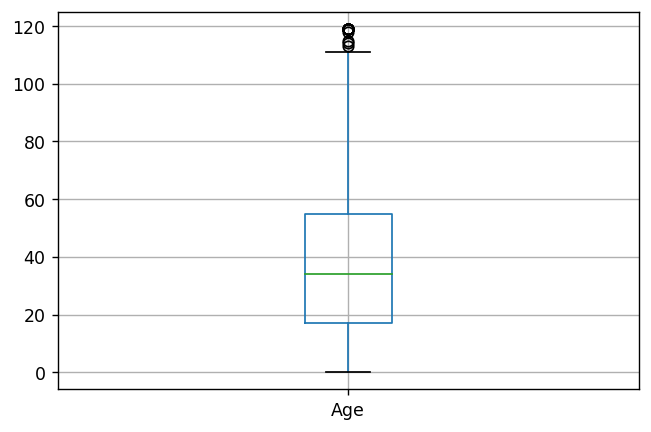

In [9]:
plt.figure(dpi=125)
bridges_age.boxplot(column='Age')

To define an "older bridge", we have chosen the upper quartile (denoted by 75%) of the age column. Approximately 25% of the oldest bridges lie above this age, which we will define as historic.

In [10]:
print("The upper quartile of Age is: ", bridges_age.Age.quantile(0.75))

The upper quartile of Age is:  55.0


As a result, any bridge that is 55 years old or younger will be retained for the purpose of the analysis. The updated dataframe is shown below.

In [11]:
# Select the data where value in age column is less than or equal to 55
bridges_new = bridges_age.loc[(bridges_age.Age <= 55)]
bridges_new

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15
000021580-00093,2005,150,4.0,Concrete,Beam,Very Good,Very Good,Very Good,14
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23


### Section 1.2: Grouping the Materials and Design

In this section we will look further at the categorical variables, material and design, with the aim of simplifying them to facilitate analysis.

Below is a summary of the number of bridges made from each material. It is evident that are are much smaller categories (shown below).

In [12]:
# Group the data by material type
gbyMat = bridges.groupby(by = 'Material')

# Return the count of each material subtype
gbyMat.size()

Material
Concrete    27123
Masonry        13
Other          48
Steel        6637
Timber        465
dtype: int64

The number of bridges built from 'Masonry' and 'Timber' are relatively small when compared to 'Concrete' and 'Steel'. They have been combined with the 'Other' materials. Thus, three categories of material will remain, under a new column named 'Simplified_Material'.

In [13]:
# Define a new type for the simplified material rating
simp_mat_type = pd.CategoricalDtype(categories=['Other', 'Concrete', 'Steel'], ordered=False)

# Dictionary for simplified material, mapping the values to be merged to a new value
simp_mat = {'Masonry':'Other', 'Timber':'Other'}

# This function maps the values where appropriate, otherwise returns the existing material
def simp_mat_rating(row):
    if row.Material in simp_mat:
        return simp_mat[row.Material]
    return row.Material

# Apply the above function, create a new column and ensure correct Dtype
bridges_simp_mat = bridges_new.assign(Simplified_Material = bridges.apply(simp_mat_rating, axis=1))
bridges_simp_mat = bridges_simp_mat.astype({'Simplified_Material':simp_mat_type})
bridges_simp_mat

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Simplified_Material
Structure_id,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14,Concrete
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14,Concrete
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7,Concrete
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15,Concrete
000021580-00093,2005,150,4.0,Concrete,Beam,Very Good,Very Good,Very Good,14,Concrete
...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25,Concrete
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19,Concrete
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23,Concrete


A similar process was carried out to determine the counts for each of the designs.

In [14]:
# Group the data by design type
gbyDesign = bridges.groupby(by = 'Design')

# Return the count of each design subtype
gbyDesign.size()

Design
Arch            159
Beam          28324
Frame            68
Movable          13
Other          1240
Slab           4340
Suspension        5
Truss           137
dtype: int64

The smaller subgroups are: Arch, Frame, Movable, Suspension and Truss. These were all grouped into the Other subgroup, under a new column named 'Simplified_Design' and three categories of design remain.

In [15]:
# Define a new type for the simplified design rating
simp_des_type = pd.CategoricalDtype(categories=['Other', 'Beam', 'Slab'], ordered=False)

# Dictionary for simplified design, mapping the values to be merged to a new value
simp_des = {'Arch':'Other', 'Frame':'Other', 'Movable':'Other', 'Suspension':'Other', 'Truss': 'Other'}

# This function maps the values where appropriate, otherwise returns the existing design
def simp_des_rating(row):
    if row.Design in simp_des:
        return simp_des[row.Design]
    return row.Design

# Apply the above function, create a new column and ensure correct Dtype
bridges_simp_des = bridges_simp_mat.assign(Simplified_Design = bridges.apply(simp_des_rating, axis=1))
bridges_simp_des = bridges_simp_des.astype({'Simplified_Design':simp_des_type})
bridges_simp_des

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Simplified_Material,Simplified_Design
Structure_id,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14,Concrete,Slab
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14,Concrete,Slab
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7,Concrete,Beam
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15,Concrete,Beam
000021580-00093,2005,150,4.0,Concrete,Beam,Very Good,Very Good,Very Good,14,Concrete,Beam
...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25,Concrete,Beam
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19,Concrete,Beam
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23,Concrete,Beam


### Section 1.3: Determining the Current Condition

The current condition will be derived from the deck, superstructure and substructure ratings. To quantify the current condition, we will convert the ratings to an integer (score 0 for Failed, 1 for Failing, 2 for Critical and so on, up to a score of 9 for Excellent). Attributes for the corresponding converted values 'DeckInt', 'SuperstrInt' and 'SubstrInt' were added to the dataframe.

In [16]:
# Dictionary for the condition score, mapping the values to be scored to a number on scale 0-9
condition_to_integer = {'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4, 'Fair': 5, 
                'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9}

# The functions below map the values in the Deck_rating, Superstr_rating and Substr_rating to the values defined above
def deck_to_int(row):
    if row.Deck_rating in condition_to_integer:
        return condition_to_integer[row.Deck_rating]
    return row.Deck_rating


def superstr_to_int(row):
    if row.Superstr_rating in condition_to_integer:
        return condition_to_integer[row.Superstr_rating]
    return row.Superstr_rating


def substr_to_int(row):
    if row.Substr_rating in condition_to_integer:
        return condition_to_integer[row.Substr_rating]
    return row.Substr_rating


# All three above functions are applied at once, assigning new columns for each
df_rating_to_int = bridges_simp_des.assign(DeckInt = bridges.apply(deck_to_int, axis=1), 
                                         SuperstrInt = bridges.apply(superstr_to_int, axis=1), 
                                         SubstrInt = bridges.apply(substr_to_int, axis=1))

df_rating_to_int

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Simplified_Material,Simplified_Design,DeckInt,SuperstrInt,SubstrInt
Structure_id,,,,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14,Concrete,Slab,7,8,8
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14,Concrete,Slab,7,7,8
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7,Concrete,Beam,8,8,8
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15,Concrete,Beam,7,8,8
000021580-00093,2005,150,4.0,Concrete,Beam,Very Good,Very Good,Very Good,14,Concrete,Beam,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25,Concrete,Beam,7,7,7
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19,Concrete,Beam,7,7,7
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23,Concrete,Beam,7,7,7


These scores have been summed in a new column called 'Current_Condition' to derive the overall condition score.

In [17]:
# Function to sum the scores in the three new columns added above
def calculate_condition(row):
    return row['DeckInt'] + row['SuperstrInt'] + row['SubstrInt']

# Applies the function to calcluate current condition score, and creates a new column
df_score = df_rating_to_int.assign(Current_Condition = df_rating_to_int.apply(calculate_condition, axis=1))

df_score

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Age,Simplified_Material,Simplified_Design,DeckInt,SuperstrInt,SubstrInt,Current_Condition
Structure_id,,,,,,,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good,14,Concrete,Slab,7,8,8,23
000021521-00181,2005,1,0.0,Concrete,Slab,Good,Good,Very Good,14,Concrete,Slab,7,7,8,22
000021521-TMP20,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good,7,Concrete,Beam,8,8,8,24
000021580-00092,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good,15,Concrete,Beam,7,8,8,23
000021580-00093,2005,150,4.0,Concrete,Beam,Very Good,Very Good,Very Good,14,Concrete,Beam,8,8,8,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,40.0,Concrete,Beam,Good,Good,Good,25,Concrete,Beam,7,7,7,21
DAPFORHOO000013,2000,300,40.0,Concrete,Beam,Good,Good,Good,19,Concrete,Beam,7,7,7,21
DAPFORHOO000015,1996,1200,25.0,Concrete,Beam,Good,Good,Good,23,Concrete,Beam,7,7,7,21


### Section 1.4: Finalising the Data for Analysis

After cleaning the data and creating the relevant new variables, the older variables from which they were derived are now redundant for the purpose of this analysis. Below is the dataframe that will be used for analysis, as it contains all the variables for investigation and the single target variable.

In [18]:
# Selection of the relevant variables required for further analysis
df_analysis = df_score.loc[:, ['Age', 'AverageDaily', 'Trucks_percent', 'Simplified_Material', 'Simplified_Design', 'Current_Condition']]
df_analysis

,Age,AverageDaily,Trucks_percent,Simplified_Material,Simplified_Design,Current_Condition
Structure_id,,,,,,
000021521-00101,14,1,0.0,Concrete,Slab,23
000021521-00181,14,1,0.0,Concrete,Slab,22
000021521-TMP20,7,100,0.0,Concrete,Beam,24
000021580-00092,15,150,4.0,Concrete,Beam,23
000021580-00093,14,150,4.0,Concrete,Beam,24
...,...,...,...,...,...,...
DAPFORHOO000012,25,300,40.0,Concrete,Beam,21
DAPFORHOO000013,19,300,40.0,Concrete,Beam,21
DAPFORHOO000015,23,1200,25.0,Concrete,Beam,21


## Section 2: Exploring Relationships Between the Investigatory and Target Variables

In this section we will explore the relationships between each of the attributes in the dataframe created for analysis at the end of section 1. The variables are a mixture of continuous (Age, AverageDaily, Trucks_percent, Current_Condition) and categorical (Simplified_Material, Simplified_Design). We will select appropriate techniques and visualisations to better understand the relationships between each combination of variables.

### Section 2.1: Correlation Matrix of the Continuous Variables

To explore the correlation between the continuous variables, a correlation matrix (heatmap) has been generated below. Correlation enables us to look at how two variables change with respect to each other. For each pair of variables, it returns a value between -1 and 1. A value greater than 0 indicates a positive correlation (as one variable increases, so does the other) and a larger value suggests a stronger correlation. On the other hand, a value less than 0 would indicate a negative correlation (as one variable increases, the other decreases), with larger values suggesting a stronger correlation. The colours of the correlation matrix below reflect the strength of the correlation (darker indicates a stronger correlation). Note that, although two variables may be correlated, this does not always imply causality (the change in one variable with respect to another may be caused by other factors).

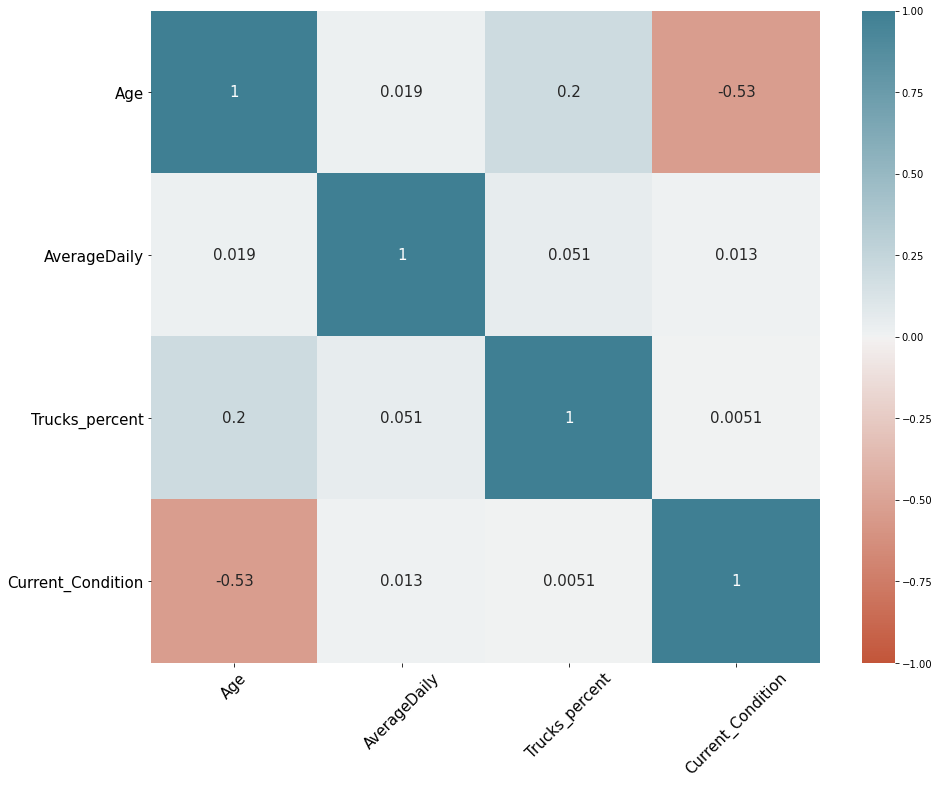

In [19]:
# Generate a heatmap for the continuous variables
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(df_analysis.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

From the above correlation matrix, we can learn more about the relationships between the continuous variables being investigated. The strongest correlation exists between Age and Current_Condition, demonstrated by its absolute value (0.53). As it is less than 0, this implies a negative correlation - as the age increases, the current condition of the bridge decreases. This aligns with expectations, one could expect wear and tear of the bridge material over time due to corrosion for example.

Very weakly positive correlations exist between the AverageDaily or Trucks_percent and Current_Condition. This would suggest that, with increases in the average daily traffic or percentage of trucks that make up this traffic, the condition of bridges improves. Although this is contrary to expectations (as we could expect increased usage to detriment the bridge condition), the magnitude of the correlations suggest that these relationships are relatively insignificant.

Similarly, there are very weak positive correlations between the AverageDaily and Trucks_percent or Age. This would suggest that increases in the average daily use is associated with a greater percentage of trucks, as well as older age. Perhaps these older bridges were built sooner to cover important routes e.g. for transportation of cargo.

There apppears to be a somewhat notable positive correlation between the Trucks_percent and Age (which shows that the percentage of traffic made up of trucks on a bridge increases with age). It is unlikely that this relationship implies causality, rather it would be a coincidence that older bridges tend to experience relatively more truck traffic.


### Section 2.2: Relationships Between the Categorical Variables

This subsection focuses on relationships between the two categorical variables, Material and Design (which were earlier simplified to Simplified_Material and Simplified_Design respectively). One of the methods we will be using to achieve this is cross-tabulation with normalisation. The resulting table records the occurences (probability) in the data where one entry (a bridge) is made up of a certain type of material and design, which we have converted to a percentage.

In [20]:
# Joint probability, normalising all. One without margins and the other with margins (both are used for different visualisations)
simpmat_and_simpdes = pd.crosstab(df_analysis.Simplified_Design, [df_analysis.Simplified_Material], normalize='all')
simpmat_and_simpdes_margins = pd.crosstab(df_analysis.Simplified_Design, [df_analysis.Simplified_Material], normalize='all', margins=True)

# Conditional probabilities normalised by index. One for each category in index and column
simpmat_given_simpdes = pd.crosstab(df_analysis.Simplified_Design, [df_analysis.Simplified_Material], normalize='index')
simpdes_given_simpmat = pd.crosstab(df_analysis.Simplified_Material, [df_analysis.Simplified_Design], normalize='index')


# Conversion to percentage and rounding for easier interpretation
rounded_simpmat_and_simpdes_margins = simpmat_and_simpdes_margins.round(4) * 100
rounded_simpmat_given_simpdes = simpmat_given_simpdes.round(4) * 100
rounded_simpdes_given_simpmat = simpdes_given_simpmat.round(4) * 100

rounded_simpmat_and_simpdes_margins

Simplified_Material,Other,Concrete,Steel,All
Simplified_Design,,,,
Other,0.15,3.71,1.21,5.08
Beam,1.50,70.85,16.28,88.63
Slab,0.00,6.29,0.00,6.29
All,1.65,80.86,17.49,100.00


The above table tells us more about the distribution of the categorical data. We can see that approximately 81% of all bridges are made from concrete, 17% from steel and the remaining 2% from other materials. With respect to design, the majority of bridges (89%) are beam, 6% slab and the remaining 5% from other designs.

Subsequently, most bridges are made up from material concrete and design beam. The second most likely combination is that of material steel and design beam. There are no bridges that are designed with slab and made with the other materials or steel, which may suggest that these combinations are not compatible. 

The bar chart below is a visual representation of the data described above. Note that the percentages are now expressed as decimal numbers.

Text(0, 0.5, 'Probability')

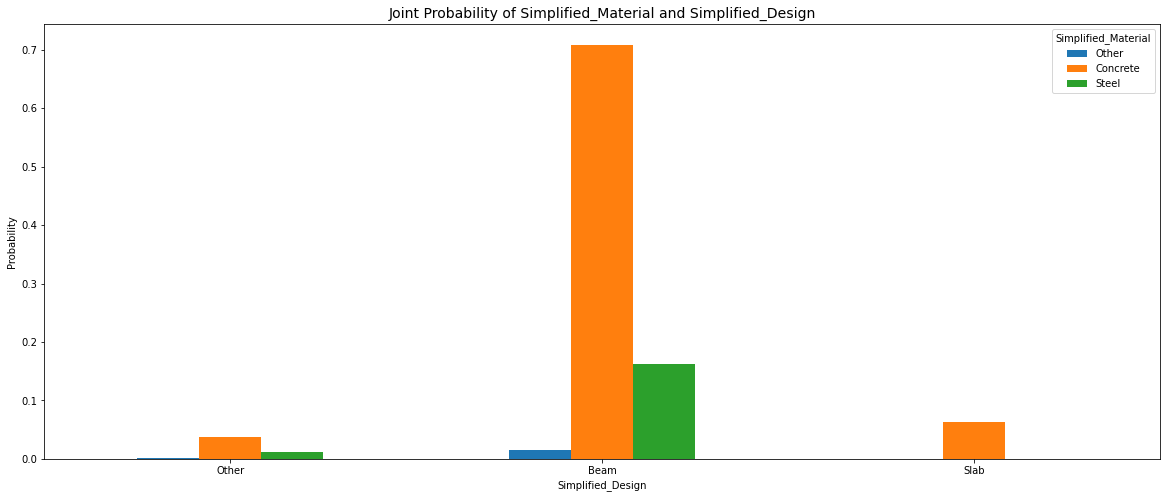

In [21]:
# Plotting the joint probability distribution
fig,(a1) = plt.subplots(1,1,figsize=(20,8))
simpmat_and_simpdes.plot(kind='bar', subplots=False, ax=a1, stacked = False, rot=0)
a1.set_title('Joint Probability of Simplified_Material and Simplified_Design', fontsize=14)
a1.set_ylabel("Probability")

In addition to joint probabilities, we can look further into the proportions of bridges built from each material that are a certain design and vice versa. These are known as conditional probabilities, for example we can ask "Of the bridges built from concrete, what is probability of the design being beam?". The heatmaps below display the cross tabulation of the design, given that the bridge is made of a certain material and vice versa. Normalisation by the index (the variable that is given by each row) simply indicates that addition of the percentages in the rows will total to 100%.

Text(0.5, 1.0, 'Simplified_Material given Simplified_Design, normalised by index')

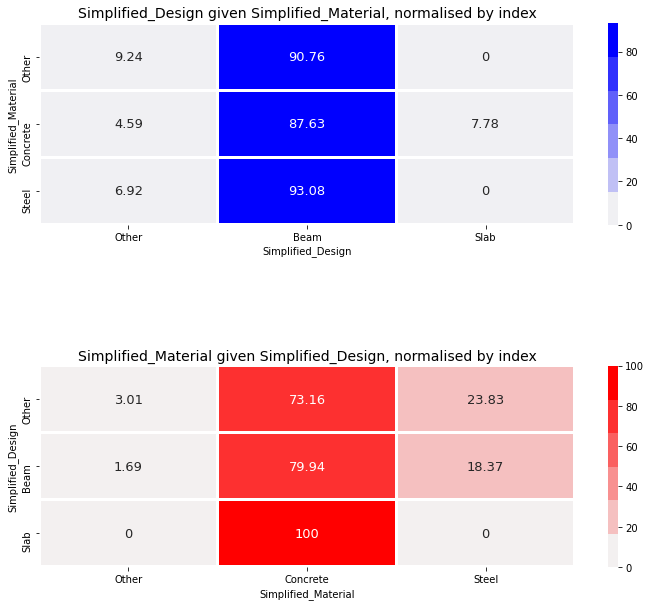

In [22]:
# Creating the heatmaps of conditional probabilities
fig, (ax, ax1) = plt.subplots(2,1, figsize=(12,10))
fig.subplots_adjust(hspace=0.7)
sns.heatmap(rounded_simpdes_given_simpmat, cmap=sns.light_palette('blue'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
sns.heatmap(rounded_simpmat_given_simpdes, cmap=sns.light_palette('red'), linewidths = 2,
            annot=True, ax=ax1, annot_kws={"size": 13}, fmt='g')


ax.set_title('Simplified_Design given Simplified_Material, normalised by index', fontsize=14)
ax1.set_title('Simplified_Material given Simplified_Design, normalised by index', fontsize=14)

The first table shows that most of the bridges made up of either the concrete, steel or other materials are designed with beam. Similarly, the second table shows that of all bridges with a certain design, the majority of these are made up of concrete. Notably, approximately 20% of all bridges designed with beam or materials in the other category are made from steel. For a more visual interpretation, the corresponding bar charts can be seen below.

Text(0, 0.5, 'Probability')

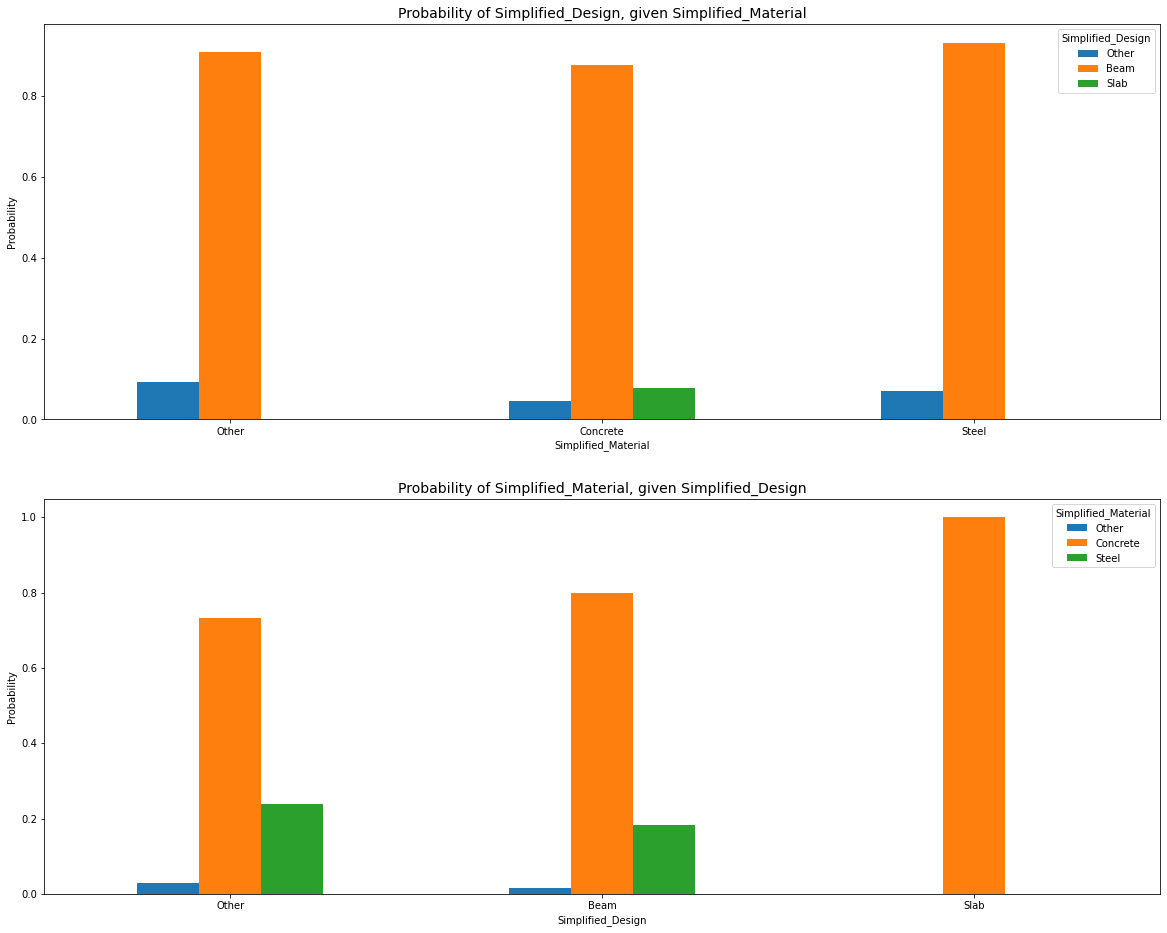

In [23]:
# Plotting each of the conditional probability distributions,corresponding to the heatmaps above
fig,(a1, a2) = plt.subplots(2,1,figsize=(20,16), sharey=False, sharex=False)

simpdes_given_simpmat.plot(kind='bar', subplots=False, ax=a1, stacked = False, rot=0)
a1.set_title('Probability of Simplified_Design, given Simplified_Material', fontsize=14)
a1.set_ylabel("Probability")

simpmat_given_simpdes.plot(kind='bar', subplots=False, ax=a2, stacked = False, rot=0)
a2.set_title('Probability of Simplified_Material, given Simplified_Design', fontsize=14)
a2.set_ylabel("Probability")

Overall, we can see that the material concrete and design beam predominate the dataset. Therefore, any conclusions drawn with respect to the effect of material and design choice on the current condition of bridges is likely to be skewed by these two subcategories.

### Section 2.3: Relationships Between the Categorical and Continuous Variables

Now that relationships within the sets of the categorical and continuous variables have been explored, we can look at the effects of the materials and designs on the continuous data. To visualise this, boxplots will be utilised which summarise the key statistics of a distribution (which were explained previously in section 1). In this way, we will have an idea of the general distribution of each continuous variable and their relationships with the categorical variables.

Below are a series of boxplots for the continuous variables, against each of the simplified material types. For the AverageDaily, the log of values was taken to aid visualisation (which was added to the dataframe as 'AverageDailyLog').

As the log version of the Trucks_percent boxplots were not clear in visualisation, alternative methods will be used to explore its relationships with the categorical variables, later in this section.

Note: a runtime warning would be generated as some AverageDaily values are zero, which does not have a logarithm. However, the boxplot is still generated for the remaining values and this error can be ignored.

C:\Users\Somil\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Current_Condition')

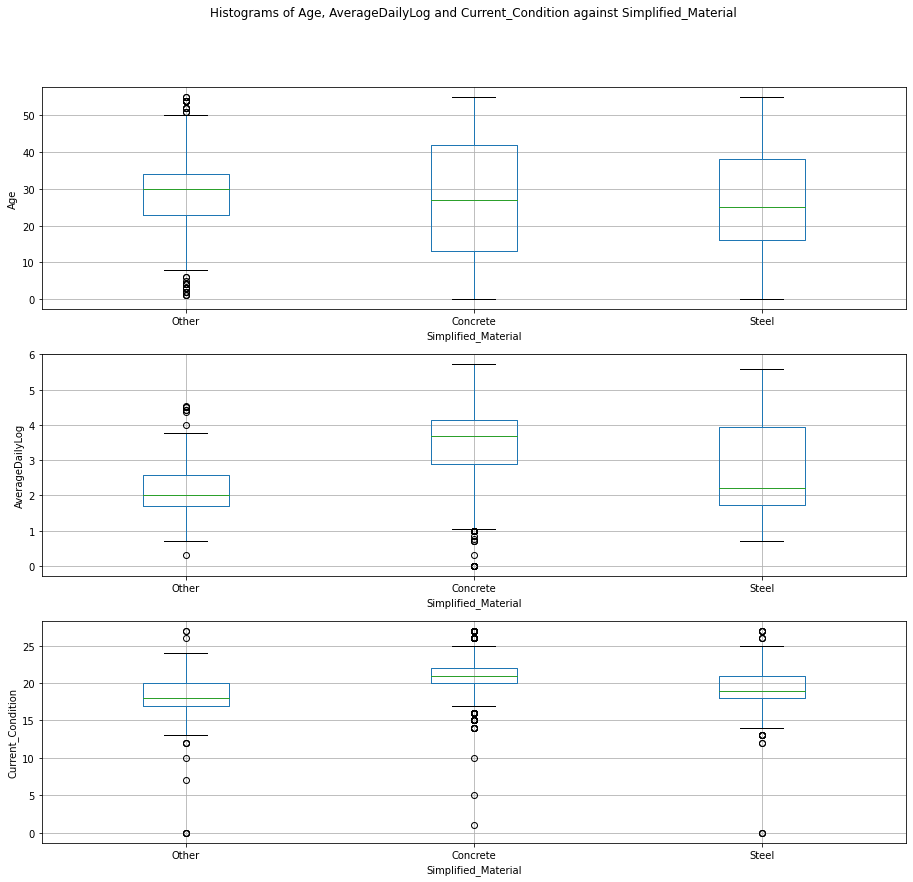

In [24]:
# Generating boxplots for the simplified material type and AverageDaily, Age and Current_Condition
fig, (a1, a2, a3) = plt.subplots(3,1, figsize=(15,14))

# Take the log of AverageDaily and assign as column under a new dataframe called brd_logs
brd_logs = df_analysis.assign(AverageDailyLog = np.log10(df_analysis.AverageDaily))

df_analysis.boxplot(column='Age', by='Simplified_Material', ax=a1)
brd_logs.boxplot(column='AverageDailyLog', by='Simplified_Material', ax=a2)
df_analysis.boxplot(column='Current_Condition', by='Simplified_Material', ax=a3)

# Labelling the title and axes for easier interpretation
fig.suptitle('Histograms of Age, AverageDailyLog and Current_Condition against Simplified_Material')
[a.set_title('') for a in [a1, a2, a3]]
a1.set_ylabel('Age')
a2.set_ylabel('AverageDailyLog')
a3.set_ylabel('Current_Condition')

From the boxplot of simplified material type against age, we can see that the middle 50% of values for concrete covers the largest range of ages (it has been used for older and newer bridges). This could be expected as the majority of bridges are made from concrete suggesting its popularity, as was seen in the previous subsection. The age distribution for other materials shows that they are popular amongst relatively older bridges, when compared to both concrete and steel.

In general, the average daily traffic appears to be the greatest for bridges built from concrete, followed by steel and other materials. This correlates well with their popularities as building materials (discussed previously). We could expect the daily traffic to be correlated with the popularity of the route the bridge is part of, as opposed to the materials they are built from. Hence, popular materials are more likely to be used to build bridges across routes with high traffic.

Bridges built from concrete tend to have the highest current condition score. The distributions of the scores for steel and other materials do not appear to be very dissimilar; but those of steel are generally in a better condition than that of the other materials. This also correlates with their popularity as building materials - it would be expected that more popular materials such as concrete have desirable effects on the condition of a bridge.

Similar box plots for the same continuous variables against simplified design type are shown below.

Text(0, 0.5, 'Current_Condition')

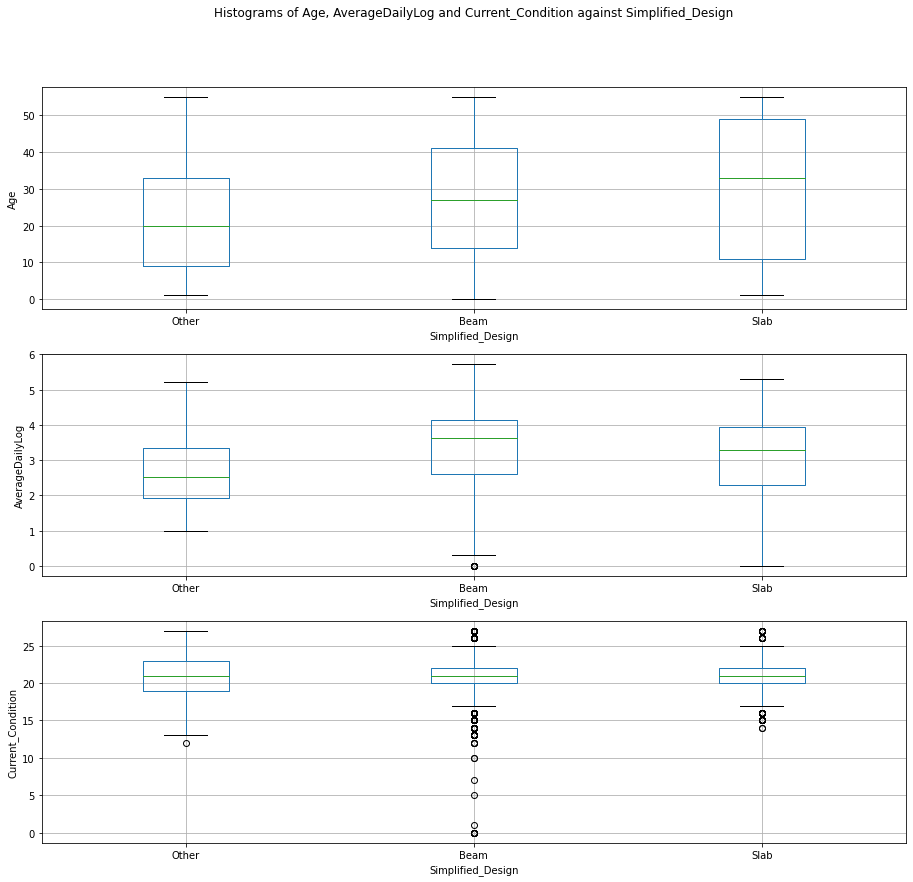

In [25]:
# Generating boxplots for the simplified design type and AverageDaily, Age and Current_Condition
fig, (a1, a2, a3) = plt.subplots(3,1, figsize=(15,14))

df_analysis.boxplot(column='Age', by='Simplified_Design', ax=a1)
brd_logs.boxplot(column='AverageDailyLog', by='Simplified_Design', ax=a2)
df_analysis.boxplot(column='Current_Condition', by='Simplified_Design', ax=a3)


# Labelling the title and axes for easier interpretation
fig.suptitle('Histograms of Age, AverageDailyLog and Current_Condition against Simplified_Design')
[a.set_title('') for a in [a1, a2, a3]]
a1.set_ylabel('Age')
a2.set_ylabel('AverageDailyLog')
a3.set_ylabel('Current_Condition')

The age distribution of bridges with design type slab appears to be the most variated, as indicated by its larger interquartile range. It also appears to be the most popular amongst older bridges, as the upper quartile extends up to approximately 51 years of age (which is higher than beam and other). Bridges with other designs tend to be younger; suggesting they are the most popular in recent times. The age distribution for design beam is somewhere in between.

The average daily traffic is generally greater for bridges with design beam, followed by slab and then other. This may correlate with their popularity as design types, as discussed in the previous subsection. There is a greater likelihood that, if there are more bridges for a given design type, such bridges could experience more traffic as they are used for popular routes.

The current condition scores appear slightly higher for design type other. This could be explained as there are fewer bridges designed in this way, and the majority of them are built from concrete (which could result in a higher condition score). However, the lower quartile for the other design type is lower than that of beam and slab, indicating a greater spread of values and that some of these bridges are in worse condition. The scores for beam and slab are not far behind, and both appear to have similar distributions as their quartiles are almost aligned.

To look at the relationship between material/design and the percentage of daily traffic that is trucks, we will use histograms. The corresponding visualisations have been generated below. The logarithm (as explained earlier) of the bridge frequency has been taken to facilitate analysis.

Text(0.5, 0, 'Trucks_percent')

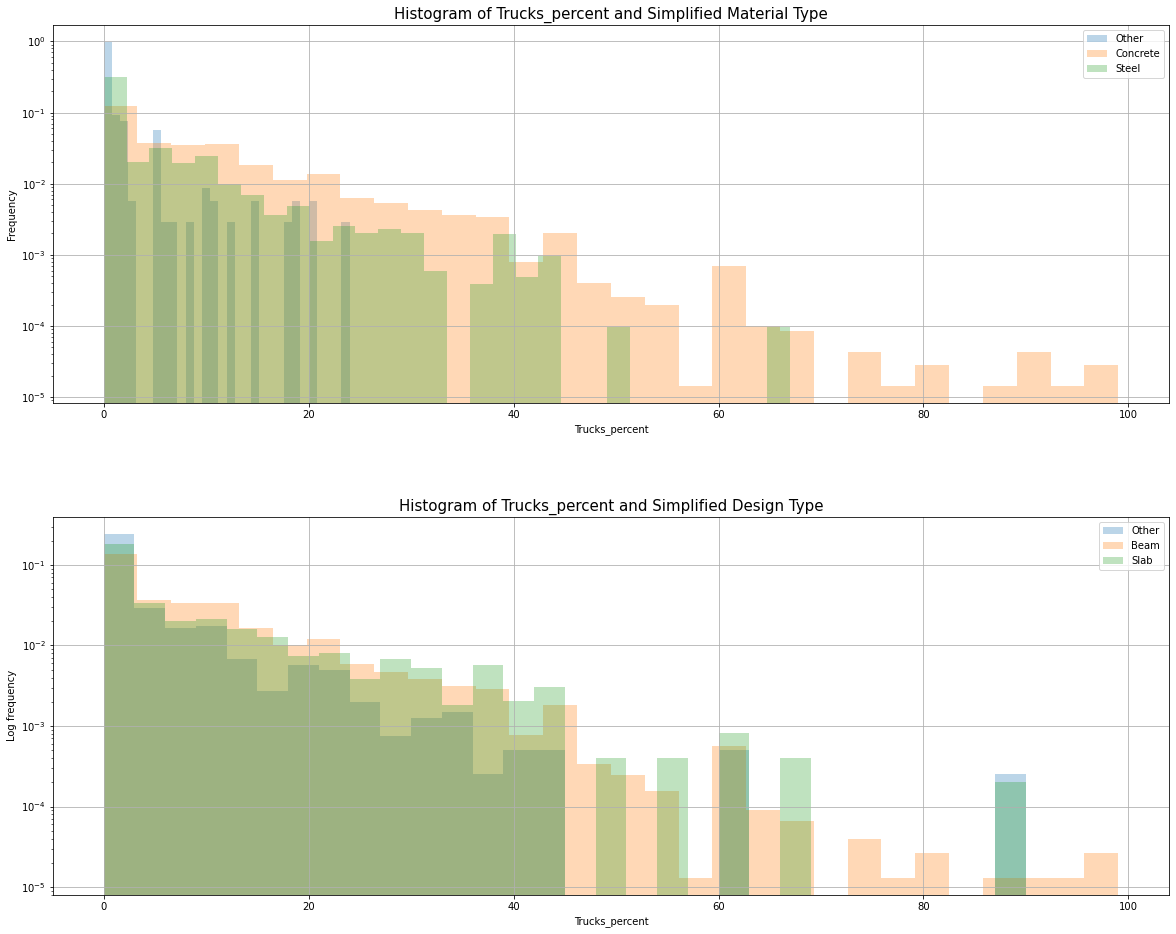

In [26]:
# Group the simplified materials and design types
gbySimpMat = df_analysis.groupby(by = 'Simplified_Material')
gbySimpDes = df_analysis.groupby(by = 'Simplified_Design')

# Creating two histograms, one for each of material and design, for Trucks_percent. The log of y-axis has been taken to aid visualisation
fig, (a1, a2) = plt.subplots(2, 1, figsize=(20,16))
gbySimpMat.hist(column=['Trucks_percent'], ax = a1, alpha=0.3, bins=30, density=True, log=True)
material = ['Other', 'Concrete', 'Steel']
a1.legend(material)
a1.set_title('Histogram of Trucks_percent and Simplified Material Type', fontsize=15)
a1.set_ylabel("Frequency")
a1.set_xlabel("Trucks_percent")


gbySimpDes.hist(column=['Trucks_percent'], ax = a2, alpha=0.3, bins=30, density=True, log=True)
design = ['Other', 'Beam', 'Slab']
a2.legend(design)
a2.set_title('Histogram of Trucks_percent and Simplified Design Type', fontsize=15)
a2.set_ylabel("Log frequency")
a2.set_xlabel("Trucks_percent")

Looking at the distribution of percentage trucks for the different materials, the values for concrete show the greatest spread, followed by steel and then other materials. This is likely associated with the corresponding popularity of the material. For more bridges that are built of a certain material, there is a greater likelihood that some of the bridges will experience different traffic (which we could expect to depend on the location/route). The range of the Trucks_percent amongst other material types is considerably lower, which may suggest that these routes are less attractive for truck drivers or may have load restrictions.

Whereas, the distribution of trucks percent for the different design types is generally more spread out. The greatest variation is seen for those designed with beam, which is expected as it is the predominant design type. Overall, there does not appear to be any surprising relationship between these two categorical variables and the percentage of daily traffic that is trucks, which may be expected.

### Section 2.4: Summarising the Relationships and Preliminary Conclusions

We have now explored relationships between each of the continuous and categorical variables, as well as their effect on the target variable. Here we will summarise the key points from the relationships observed in this section:
* There seems to be a strong effect of age on predicting the bridge condition, with older bridges typically being in worse condition.
* There is a lack of correlation between the average daily traffic or the percentage of this traffic that is trucks, and the condition of the bridge. This is contrary to expectations as increased traffic (and weight of traffic) would be expected to cause wear and tear.
* The vast majority of bridges are built from concrete, which generally are in the best condition (have the highest current condition score), followed by steel and then other materials. Their popularity may reflect their ability to preserve the bridge quality.
* The current condition of bridges with each design type  are similar. The beam design is most popular, but its distribution of condition scores is very similar to that of slab. This may suggest that factors other than design type could be more influential on determining the overall bridge condition.
* Overall, we could expect age and material type to have the greatest influences on the current condition of a bridge.
* There is not much to suggest significant co-linearity (correlation) between any of our predictor variables, which is better for the construction of a regression model.

## Section 3: Creating the Prediction Model

In this section we will construct a linear regression model which looks at the effect of the five predictor variables on the current condition of bridges. This creates a mathematical formula for a  plane that best fits the predictor and target variables involved. It returns a value for each predictor and how it can affect the target variable. This will be further explained below.

### Section 3.1: Preparing the Categorical Predictors

Categorical values are not suitable to be directly placed in a regression model, which takes numerical predictors. Therefore, the two categorical predictors (Simplified_Material and Simplified_Design) must first be transformed using reference encoding (explained below). The result of this process is demonstrated using the example for Simplified_Material.

In [27]:
# Reference encoding for the categorical variables
SimpMat_d = pd.get_dummies(df_analysis.Simplified_Material, drop_first=True)
SimpDes_d = pd.get_dummies(df_analysis.Simplified_Design, drop_first=True)

# Example of the reference encoding result
SimpMat_d

,Concrete,Steel
Structure_id,,
000021521-00101,1,0
000021521-00181,1,0
000021521-TMP20,1,0
000021580-00092,1,0
000021580-00093,1,0
...,...,...
DAPFORHOO000012,1,0
DAPFORHOO000013,1,0
DAPFORHOO000015,1,0


As can be seen above, the Simplified_Material has been divided into the individual material groups. The presence of the number 1 in a column indicates that a particular bridge is made of the corresponding material. For example, we can see that the bridge in the first row is made up of concrete. In both cases, the first categorical variable (other material and other design) have been used as a reference, so a value of 0 in both concrete and steel would imply a bridge is made up of other materials. The reference column also ensures that the remaining columns become linearly independent, and enables fair comparisons between the effect of categorical predictors.

### Section 3.2: Determining the Regression Coefficients

Now that all five of the predictor variables have been prepared, we will calculate the respective regression coefficients of determination using the linear regression model. In this regression model, the predictor variables are independent, and the current condition is the dependent variable. 

The below table summarises the results of the regression model. It includes columns for the 'Predictor Variable', the corresponding 'Regression Coefficient' as calculated by the model and the units of the 'Change in Current Condition (units)' in relation to the predictor. 

We have also calculated the 'Change in Current Condition as a Percentage of its range' to facilitate interpretation of the results, which for a given predictor variable is the regression coefficient multiplied by its range, then divided by the range of the current condition. The ranges involved have been calculated as the difference between the 10th and 90th percentiles (which enclose the middle 80% of values), except for design and material which all have a range of 1, to reduce the effect of outliers on our analysis. Note that all the numerical values in the table have been rounded to 3 decimal places.

In [28]:
# Building the regression model using the relevant predictor variables
y = df_analysis.Current_Condition
X = np.column_stack((df_analysis.Age, df_analysis.AverageDaily, df_analysis.Trucks_percent, SimpMat_d.Concrete, 
                     SimpMat_d.Steel, SimpDes_d.Beam, SimpDes_d.Slab))

reg = LinearRegression().fit(X, y)
beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_MatConcrete, beta_MatSteel, beta_DesBeam, beta_DesSlab = reg.coef_

# Calculating the range for each of the continuous variables, given by 90th percentile - 10th percentile (excluding outliers)
Age_range = df_analysis.Age.quantile(0.9) - df_analysis.Age.quantile(0.1)
AverageDaily_range = df_analysis.AverageDaily.quantile(0.9) - df_analysis.AverageDaily.quantile(0.1)
Trucks_percent_range = df_analysis.Trucks_percent.quantile(0.9) - df_analysis.Trucks_percent.quantile(0.1)
CurrentCondition_range = df_analysis.Current_Condition.quantile(0.9) - df_analysis.Current_Condition.quantile(0.1)

# Calculating the change in current condition as a percentage of the variable range
Age_POF = (100 * (beta_Age * Age_range) / CurrentCondition_range)
AverageDaily_POF = (100 * (beta_AverageDaily * AverageDaily_range) / CurrentCondition_range)
Trucks_percent_POF = (100 * (beta_Trucks_percent * Trucks_percent_range) / CurrentCondition_range)
MatConcrete_POF = (100 * beta_MatConcrete / CurrentCondition_range)
MatSteel_POF = (100 * beta_MatSteel / CurrentCondition_range)
DesBeam_POF = (100 * beta_DesBeam / CurrentCondition_range)
DesSlab_POF = (100 * beta_DesSlab / CurrentCondition_range)


# Creating a new dataframe to summarise all the information above
df_regression = pd.DataFrame({'Predictor Variable': ['Age', 'AverageDaily', 'Trucks_percent', 'Material: Concrete', 'Material: Steel', 'Design: Beam', 'Design: Slab'],
                              'Regression Coefficient': [beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_MatConcrete, beta_MatSteel, beta_DesBeam, beta_DesSlab],
                              'Change in Current Condition (units)': ['per year', 'per average daily traffic (vehicle)', 'per percentage of daily traffic that is trucks', 'per bridge material concrete', 'per bridge material steel', 'per bridge design beam', 'per bridge design slab'],
                              'Change in Current Condition (% of  range)': [Age_POF, AverageDaily_POF, Trucks_percent_POF, MatConcrete_POF, MatSteel_POF, DesBeam_POF, DesSlab_POF]})

# Rounding the numerical values in the table to 3 decimal places
df_regression.round(3)

,Predictor Variable,Regression Coefficient,Change in Current Condition (units),Change in Current Condition (% of range)
0,Age,-0.062,per year,-54.326
1,AverageDaily,-0.000,per average daily traffic (vehicle),-0.207
2,Trucks_percent,0.006,per percentage of daily traffic that is trucks,2.387
3,Material: Concrete,2.900,per bridge material concrete,57.998
4,Material: Steel,1.284,per bridge material steel,25.676
5,Design: Beam,-0.046,per bridge design beam,-0.928
6,Design: Slab,-0.090,per bridge design slab,-1.808


Looking at the percentage change in current condition, it is evident that two of the predictors, age and material, have the greatest influence on the current condition of a bridge. This is in accordance with the relationships discussed in section 2. 

Although we do not have a regression coefficient for the other material category, the change in current condition for the concrete and steel can be explained as the effect of replacing it. Therefore, when compared to the reference category, bridges made from material concrete lead have the greatest effect on increasing the bridge condition, followed by steel and then other.

In contrast, the age of a bridge has an opposite effect to the current condition in relation to concrete, and causes the most detriment to the bridge condition.

The remaining predictors - average daily traffic, trucks percentage and design (relative to category other) appear to have very minor effects on the condition of the bridge, whether it be positive or negative. As mentioned earlier, this may be surprising for both of the daily traffic statistics. We could expect bridges with more traffic to have a greater reduction in the bridge condition.

### Section 3.3: Looking at How the Prediction Fits the Data

As expected, the mathematical prediction model would not perfectly fit all of the data points. The prediction aims to describe the data as best as possible, by minimising the distance of each data point from the predicted value. To further look at this for our model, the below histogram shows the distribution of the residuals (errors) in the current condition. They are calculated by deducting the actual current condition from the prediction derived using the model. More simply, they are a measure of how far from the regression model the data points are. The x-axis shows the range of errors and their corresponding count (frequency) is on the y-axis. Most of the errors appear to be within approximately +/- 2 condition score of zero, which suggests that our model fits the data quite well.

Text(0, 0.5, 'Frequency')

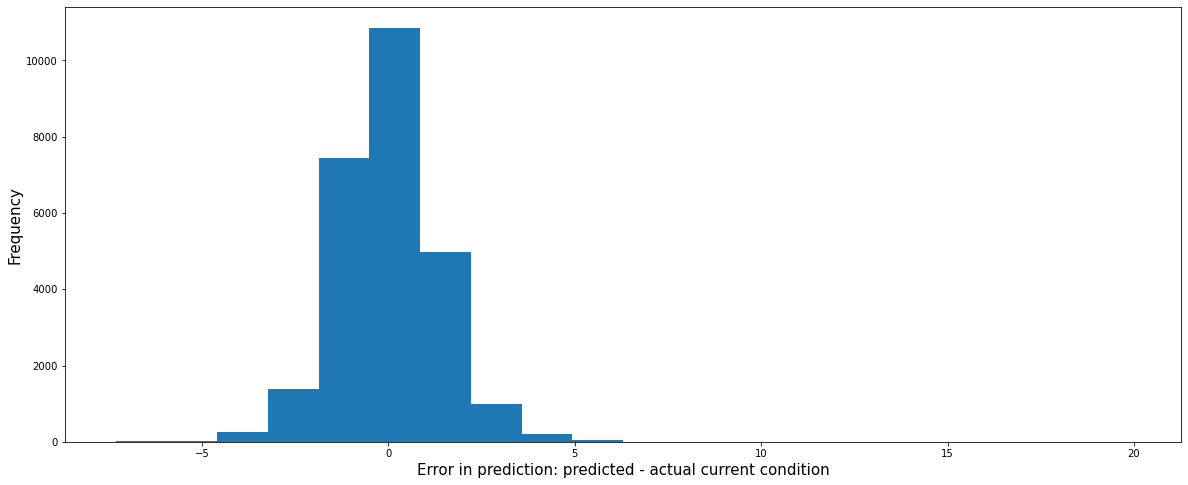

In [29]:
# Calculating the residuals
y_hat = reg.predict(X)
residuals = y_hat - y

# Plotting a histogram to show the distribution of residuals
fig, a1 = plt.subplots(1, 1, figsize=(20,8))
a1.hist(residuals, bins=20)
a1.set_xlabel('Error in prediction: predicted - actual current condition', fontsize=15)
a1.set_ylabel('Frequency', fontsize=15)

Below we have calculated the R2 coefficient (to 3 significant figures). It tells us about the proportion of the variation in the dependent variable (current condition) that is predictable from the independent variables (the predictors). It typically ranges from 0 to 1, and the higher the value it indicates a better fit for the model. In our case, the coefficient shows that approximately 44% of variation in the current condition can be explained using the five predictors. This suggests that, although the predictors cannot perfectly predict the current condition of a bridge, they may have a substantial ability to do so.

In [30]:
# Printing the R2 coefficient of determination
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))

The R2 coefficient of determination is 0.437


### Section 3.4: Conclusion

Generally, our findings in in this section are in accordance with those observed in the exploratory analysis. In summary, the regression model has allowed us to observe the effect of each studied predictor variable on the current condition of a bridge:
* It could be expected that increases in the age of a bridge, its average daily traffic and percentage of that traffic that is trucks could negatively influence the condition score. Using our model this is only evident for the age variable, which causes the greatest detriment to the bridge condition. The change in current condition for 'AverageDaily' was slightly negative, indicating a decrease in the bridge condition. For 'Trucks_percentage', there is a surprising small increase in the bridge condition. However, both of these changes are relatively insignificant as they are close to 0% (change in condition as a percentage of their range).
* Different types of material could be expected to affect the bridge condition score, for example through their varying susceptibility to corrosion. Of all the materials, concrete showed the greatest ability to maintain/improve bridge condition, followed by steel and the other simplified materials category.
* Similarly, the design of a bridge could affect structural integrity and the subsequent condition score. Although the other designs appear to be the best, followed by beam and then slab, the differences between them are not remarkable and their effects on the overall condition score are minimal. As explored in section 2, the variation in condition score between them is likely to be explained by other factors.

Of all the predictor variables investigated, two (age and material) seem to have relatively large influence on the overall bridge condition. Namely, newer bridges built from concrete appear to be in better condition. The other variables demonstrate insigificant changes that perhaps would not be ideal to incorporate in future prediction models. Going forward, analyses could shift focus to other potential predictors (readily available in the dataset) which could affect bridge condition such as scour rating, rated load, road class status (interstate or local), location (urban or rural) and compare these to the condition score.